# Stacking & Importances

## Introduction
D.H. Wolpert wrote in his famous paper "Stacked Generalization", that stacked generalization is "…a scheme for minimizing the generalization error rate of one or more generalizers. Stacked generalization works by deducing the biases of the generalizer(s) with respect to a provided learning set. This deduction proceeds by generalizing in a second space whose inputs are (for example) the guesses of the original generalizers when taught with part of the learning set and trying to guess the rest of it, and whose output is (for example) the correct guess".

Basically, a set of models (called L0 level estimator set) is trained on the train set, then a metamodel (also called L1 level estimator, that can be a regression (linear or logistic) or a decision tree) is trained on test set using predictions of the L0 level estimators. We can say that the stacking is successful when the score of the final estimator is better than the best score of the L0 level estimators.

This model can be optimized along two main axes:
- the size of L0 level estimator set
- the number of features.

To reach this goal, we can follow this procedure:
- generate an exploratory data analysis, where the correlation analysis indicates which columns must be dropped
- build a model using stacked generalization
- reduce the size of the L0 level estimator set using model importance (based on the value of the coefficients of the metamodel) 
- reduce the number of features using permutation feature importance computed on the preceding model
- build the final model with the reduced L0 level estimator set and the reduced the number of features
- store information about this process in a SQLite [database](https://www.kaggle.com/datasets/philippebillet/stacking-importance).

This process is more precisely described in the documentation of [EZStacking](https://github.com/phbillet/EZStacking), that is the tool used to generate my [notebooks](https://www.kaggle.com/philippebillet/code) on Stacking and Importances.

The goal of the present notebook is to extract information from the SQLite database to evaluate this process.


## Basic import

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
# conn = sqlite3.connect('/kaggle/input/stacking-importance/EZS_store.db')
conn = sqlite3.connect('/home/philippe/development/python/EZStacking/EZS_deps/EZS_store.db')

# List of problems

In [4]:
sql = "select name as problem, path as url from problem"
data = pd.read_sql(sql, conn)
def make_clickable(val):
    # target _blank to open new window
    return '<a target="_blank" href="{}">{}</a>'.format(val,val)

data.style.format({'url': make_clickable})

,problem,url
0,iris,https://www.kaggle.com/datasets/uciml/iris
1,concrete,https://www.kaggle.com/datasets/prathamtripathi/regression-with-neural-networking
2,Delaney solubility,https://www.kaggle.com/datasets/prashanthbairu/delaney-solubility-with-descriptors
3,Critical Heat Flux,https://www.kaggle.com/datasets/saurabhshahane/predicting-heat-flux
4,Liver disease prediction,https://www.kaggle.com/datasets/uciml/indian-liver-patient-records
5,Pumpkin Seeds,https://www.kaggle.com/datasets/muratkokludataset/pumpkin-seeds-dataset
6,water quality,https://www.kaggle.com/datasets/mssmartypants/water-quality
7,lithium ion batteries,https://www.kaggle.com/datasets/divyansh22/crystal-system-properties-for-liion-batteries
8,diabetes,https://www.kaggle.com/datasets/akshaydattatraykhare/diabetes-dataset
9,Franck-Hertz,https://www.kaggle.com/datasets/raktim711/franckhertz-experiment


# Problem repartition

How much problems are considered?

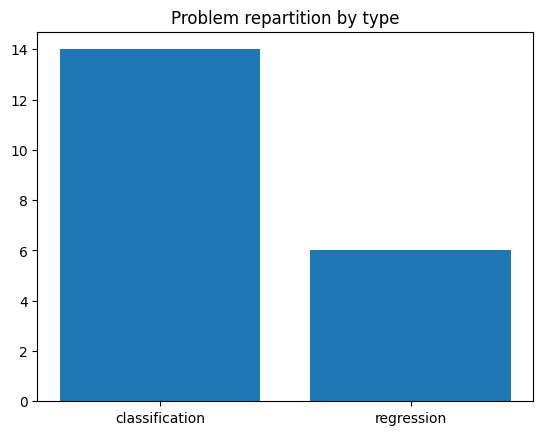

In [5]:
sql = "select type, count(*) as count from problem group by type"
data = pd.read_sql(sql, conn)
plt.bar(data['type'], data['count'])
plt.title("Problem repartition by type")
plt.show()

# Solutions of problems

How many problem solutions were developed?

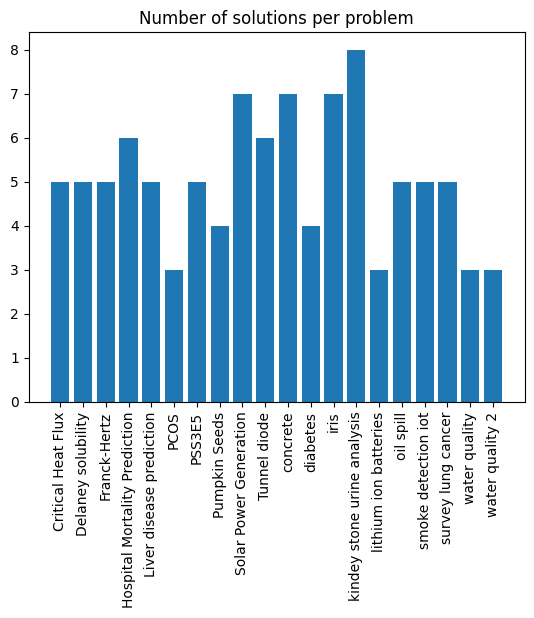

In [6]:
sql = "select name, count(*) as count from solution group by name"
data = pd.read_sql(sql, conn)
plt.bar(data['name'], data['count'])
plt.xticks(rotation='vertical')
plt.title("Number of solutions per problem")
plt.show()

# Solutions with resampling (in the case of classification problems)

If the classes are really imbalanced, it is often necessary to use resampling to reach the goal.

Which solutions use resampling?

In [7]:
sql = """select distinct P.name as name,
                S.resampling as resampling
         from problem as P
         inner join solution as S
            on P.name = S.name
         where P.type = 'classification'
         and S.resampling = 1
         union all
         select distinct P.name as name,
                S.resampling as resampling
         from problem as P
         inner join solution as S
            on P.name = S.name
         where P.type = 'classification'
         and S.resampling = 0
      """

data = pd.read_sql(sql, conn)
data.style.background_gradient(subset=["resampling"], cmap="Reds")


,name,resampling
0,Liver disease prediction,1
1,survey lung cancer,1
2,oil spill,1
3,kindey stone urine analysis,1
4,Hospital Mortality Prediction,1
5,iris,0
6,Pumpkin Seeds,0
7,water quality,0
8,lithium ion batteries,0
9,diabetes,0


# Tree or regression, which L1_models are used in the solutions? 

In [8]:
sql = """select name as solution, L1_model, count(*) as count 
         from (select name, L1_model 
               from model 
               group by name, L1_model, version) 
         group by  name, L1_model
      """

data = pd.read_sql(sql, conn)
data

,solution,L1_model,count
0,Critical Heat Flux,regression,3
1,Critical Heat Flux,tree,2
2,Delaney solubility,regression,3
3,Delaney solubility,tree,2
4,Franck-Hertz,regression,3
5,Franck-Hertz,tree,2
6,Hospital Mortality Prediction,regression,4
7,Hospital Mortality Prediction,tree,2
8,Liver disease prediction,regression,4
9,Liver disease prediction,tree,1


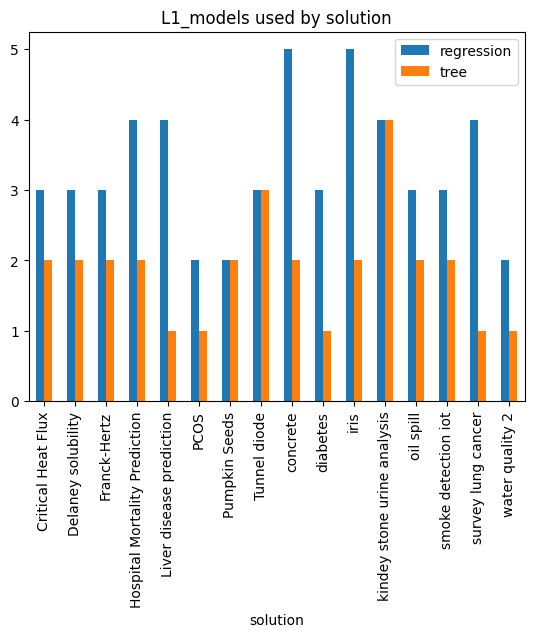

In [9]:
sql = """select reg.name as solution, reg.count as regression, tre.count as tree
           from (select name, count(*) as count -- how many regression
                 from (select name, L1_model 
                       from model 
                       where L1_model = 'regression'
                       group by name, L1_model, version) 
                 group by  name, L1_model) as reg
           inner join 
                 (select name, count(*) as count -- how many tree
                 from (select name, L1_model 
                       from model 
                       where L1_model = 'tree'
                       group by name, L1_model, version) 
                 group by  name, L1_model) as tre
           on reg.name = tre.name
        """

data = pd.read_sql(sql, conn)
data.set_index('solution').plot.bar()
plt.title("L1_models used by solution")
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

# When is the stacking successful?

The stacking is successful, when the score of the stacked estimator is greater (resp. greater or equal) than the maximal score of the estimator in level 0 (on test set) in the strong formulation (resp. in the weak formulation).

In this part, we only consider the strong formulation.

In [10]:
sql = """select A.name, A.version, A.step
        from (select name, version, step, max(test_score) as max_test_score 
              from model_score where model not in ('Stack') 
              group by name, version, step) as A
        inner join 
             (select name, version, step, test_score as stack_score 
              from model_score 
              where model = 'Stack') as B
        on A.name = B.name
        and A.version = B.version
        and A.step = B.step
        where A.max_test_score < B.stack_score
        group by A.name, A.version, A.step
      """ 

data = pd.read_sql(sql, conn)
data

,name,version,step
0,Critical Heat Flux,1,2
1,Critical Heat Flux,1,3
2,Critical Heat Flux,2,2
3,Critical Heat Flux,2,3
4,Critical Heat Flux,5,2
...,...,...,...
87,oil spill,4,2
88,oil spill,5,1
89,oil spill,5,2
90,oil spill,5,3


## For which problems did stacking work?

In [11]:
sql = """select name as problem
          from problem
          where name in (
                select distinct A.name
                from (select name, version, step, max(test_score) as max_test_score 
                      from model_score where model not in ('Stack') 
                      group by name, version, step) as A
                inner join 
                     (select name, version, step, test_score as stack_score 
                      from model_score 
                      where model = 'Stack') as B
                on A.name = B.name
                and A.version = B.version
                and A.step = B.step
                where A.max_test_score < B.stack_score)
        """

data = pd.read_sql(sql, conn)
data

,problem
0,Critical Heat Flux
1,Delaney solubility
2,Franck-Hertz
3,Hospital Mortality Prediction
4,Liver disease prediction
5,PCOS
6,PSS3E5
7,Solar Power Generation
8,Tunnel diode
9,concrete


## For which problems did stacking not work?

In [12]:
sql = """select name as problem
          from problem
          where name not in (
                select  distinct A.name
                from (select name, version, step, max(test_score) as max_test_score 
                      from model_score where model not in ('Stack') 
                      group by name, version, step) as A
                inner join 
                     (select name, version, step, test_score as stack_score 
                      from model_score 
                      where model = 'Stack') as B
                on A.name = B.name
                and A.version = B.version
                and A.step = B.step
                where A.max_test_score < B.stack_score)
        """

data = pd.read_sql(sql, conn)
data

,problem
0,Pumpkin Seeds
1,iris
2,kindey stone urine analysis
3,lithium ion batteries
4,smoke detection iot
5,water quality
6,water quality 2


# Successful stacking ratio

For a given problem, the successful stacking ratio is defined by: $SSR=\frac{NSS}{M}$

Where:
- number of model such that stacking is successful: $NSS$
- number of model: $M$

### Strong formulation

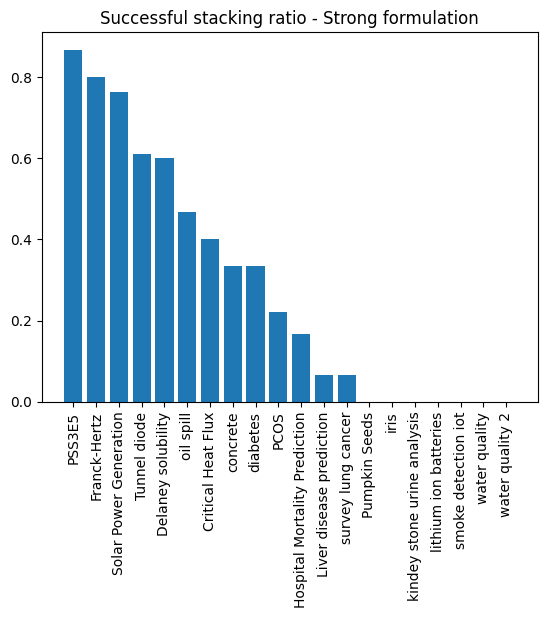

In [13]:
sql = """select total.name, ifnull((cast(stack.count as real)/cast(total.count as real)),0) as ratio
         from (select name, count(*) as count -- How many models per problem?
               from model
               group by name) as total
         left outer join
              (select A.name, count(*) as count -- How many models such that stacking worked per problem?
               from (select name, version, step, max(test_score) as max_test_score 
                     from model_score 
                     where model not in ('Stack') 
                     group by name, version, step) as A
               inner join 
                    (select name, version, step, test_score as stack_score 
                     from model_score 
                     where model = 'Stack') as B
               on A.name = B.name
               and A.version = B.version
               and A.step = B.step
               where A.max_test_score < B.stack_score
               group by A.name) as stack
         on total.name = stack.name
         order by ratio desc
      """

data = pd.read_sql(sql, conn)
plt.bar(data['name'], data['ratio'])
plt.xticks(rotation='vertical')
plt.title("Successful stacking ratio - Strong formulation")
plt.show()

### Weak formulation

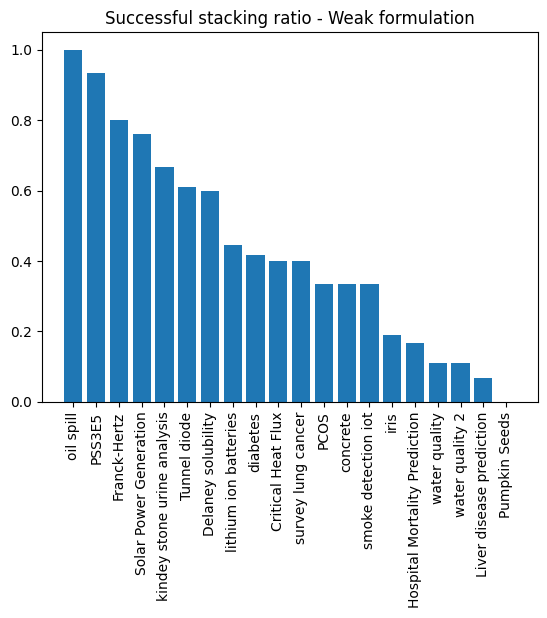

In [14]:
sql = """select total.name, ifnull((cast(stack.count as real)/cast(total.count as real)),0) as ratio
         from (select name, count(*) as count -- How many models per problem?
               from model
               group by name) as total
         left outer join
              (select A.name, count(*) as count -- How many models such that stacking worked per problem?
               from (select name, version, step, max(test_score) as max_test_score 
                     from model_score 
                     where model not in ('Stack') 
                     group by name, version, step) as A
               inner join 
                    (select name, version, step, test_score as stack_score 
                     from model_score 
                     where model = 'Stack') as B
               on A.name = B.name
               and A.version = B.version
               and A.step = B.step
               where A.max_test_score <= B.stack_score
               group by A.name) as stack
         on total.name = stack.name
         order by ratio desc
      """

data = pd.read_sql(sql, conn)
plt.bar(data['name'], data['ratio'])
plt.xticks(rotation='vertical')
plt.title("Successful stacking ratio - Weak formulation")
plt.show()

# Successfull stacking count in each step

It is also interesting to see at which step the stacking worked.

On the following graphic, for each problem, we can see:
- the total number of solution
- the number of successful stacking model at the step 1
- the number of successful stacking model at the step 2
- the number of successful stacking model at the step 3

## First solution: with joins
### Strong formulation

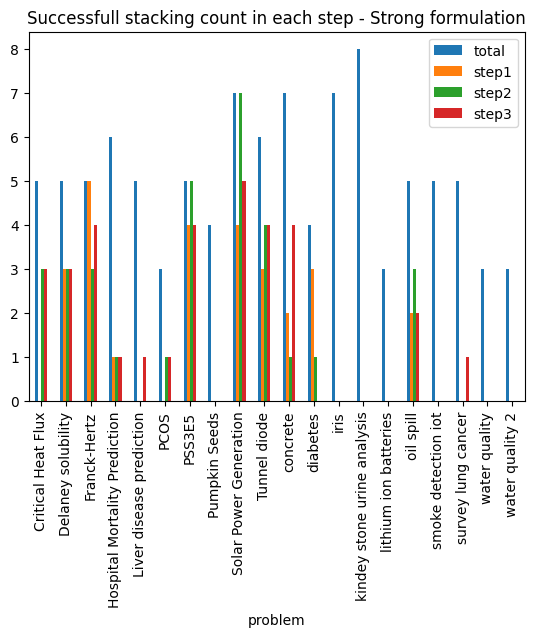

In [15]:
sql = """select total.name as problem, total.count as total, step_1.count as step1, step_2.count as step2, step_3.count as step3
         from
          (select name, count(*) as count
           from solution
           group by name) as total
         inner join  
          (select total.name, ifnull(stack.count, 0) as count
           from (select name, count(*) as count -- How many models per problem?
                 from solution
                 group by name) as total
           left outer join
                (select A.name, count(*) as count -- How many models such that stacking worked per problem?
                 from (select name, version, step, max(test_score) as max_test_score 
                       from model_score 
                       where model not in ('Stack') 
                       group by name, version, step) as A
                inner join 
                       (select name, version, step, test_score as stack_score 
                        from model_score 
                        where model = 'Stack') as B
                on A.name = B.name
                and A.version = B.version
                and A.step = B.step
                where A.max_test_score < B.stack_score
                and A.step = 1
                group by A.name) as stack
           on total.name = stack.name
           order by count desc) as step_1
         inner join
          (select total.name, ifnull(stack.count, 0) as count
           from (select name, count(*) as count -- How many models per problem?
                 from solution
                 group by name) as total
           left outer join
                (select A.name, count(*) as count -- How many models such that stacking worked per problem?
                 from (select name, version, step, max(test_score) as max_test_score 
                       from model_score 
                       where model not in ('Stack') 
                       group by name, version, step) as A
                inner join 
                       (select name, version, step, test_score as stack_score 
                        from model_score 
                        where model = 'Stack') as B
                on A.name = B.name
                and A.version = B.version
                and A.step = B.step
                where A.max_test_score < B.stack_score
                and A.step = 2
                group by A.name) as stack
           on total.name = stack.name
           order by count desc) as step_2
         inner join
          (select total.name, ifnull(stack.count, 0) as count
           from (select name, count(*) as count -- How many models per problem?
                 from solution
                 group by name) as total
           left outer join
                (select A.name, count(*) as count -- How many models such that stacking worked per problem?
                 from (select name, version, step, max(test_score) as max_test_score 
                       from model_score 
                       where model not in ('Stack') 
                       group by name, version, step) as A
                inner join 
                       (select name, version, step, test_score as stack_score 
                        from model_score 
                        where model = 'Stack') as B
                on A.name = B.name
                and A.version = B.version
                and A.step = B.step
                where A.max_test_score < B.stack_score
                and A.step = 3
                group by A.name) as stack
           on total.name = stack.name
           order by count desc) as step_3
         on step_1.name = step_2.name
         and step_1.name = step_3.name
         and total.name = step_1.name
      """

data = pd.read_sql(sql, conn)
data_1_strong = data.copy()
data.set_index('problem').plot.bar()
plt.title("Successfull stacking count in each step - Strong formulation")
plt.show()

### Weak formulation

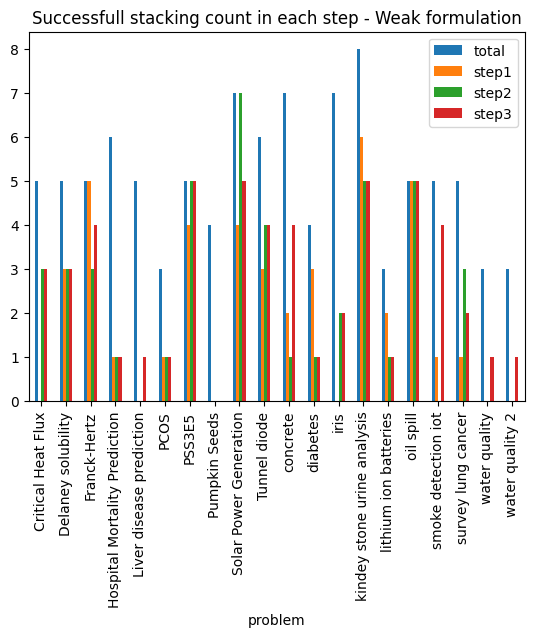

In [16]:
sql = """select total.name as problem, total.count as total, step_1.count as step1, step_2.count as step2, step_3.count as step3
         from
          (select name, count(*) as count
           from solution
           group by name) as total
         inner join  
          (select total.name, ifnull(stack.count, 0) as count
           from (select name, count(*) as count -- How many models per problem?
                 from solution
                 group by name) as total
           left outer join
                (select A.name, count(*) as count -- How many models such that stacking worked per problem?
                 from (select name, version, step, max(test_score) as max_test_score 
                       from model_score 
                       where model not in ('Stack') 
                       group by name, version, step) as A
                inner join 
                       (select name, version, step, test_score as stack_score 
                        from model_score 
                        where model = 'Stack') as B
                on A.name = B.name
                and A.version = B.version
                and A.step = B.step
                where A.max_test_score <= B.stack_score
                and A.step = 1
                group by A.name) as stack
           on total.name = stack.name
           order by count desc) as step_1
         inner join
          (select total.name, ifnull(stack.count, 0) as count
           from (select name, count(*) as count -- How many models per problem?
                 from solution
                 group by name) as total
           left outer join
                (select A.name, count(*) as count -- How many models such that stacking worked per problem?
                 from (select name, version, step, max(test_score) as max_test_score 
                       from model_score 
                       where model not in ('Stack') 
                       group by name, version, step) as A
                inner join 
                       (select name, version, step, test_score as stack_score 
                        from model_score 
                        where model = 'Stack') as B
                on A.name = B.name
                and A.version = B.version
                and A.step = B.step
                where A.max_test_score <= B.stack_score
                and A.step = 2
                group by A.name) as stack
           on total.name = stack.name
           order by count desc) as step_2
         inner join
          (select total.name, ifnull(stack.count, 0) as count
           from (select name, count(*) as count -- How many models per problem?
                 from solution
                 group by name) as total
           left outer join
                (select A.name, count(*) as count -- How many models such that stacking worked per problem?
                 from (select name, version, step, max(test_score) as max_test_score 
                       from model_score 
                       where model not in ('Stack') 
                       group by name, version, step) as A
                inner join 
                       (select name, version, step, test_score as stack_score 
                        from model_score 
                        where model = 'Stack') as B
                on A.name = B.name
                and A.version = B.version
                and A.step = B.step
                where A.max_test_score <= B.stack_score
                and A.step = 3
                group by A.name) as stack
           on total.name = stack.name
           order by count desc) as step_3
         on step_1.name = step_2.name
         and step_1.name = step_3.name
         and total.name = step_1.name
      """

data = pd.read_sql(sql, conn)
data_1_weak = data.copy()
data.set_index('problem').plot.bar()
plt.title("Successfull stacking count in each step - Weak formulation")
plt.show()

## Second solution: with views

The preceding example uses complex and hard to maintain requests.
To address this problem, two views have been added:

- ```solution_ext```: this view can be viewed as an redefinition of the table solution
```
select name, version, L1_model
from model
group by name, version, L1_model
order by name
```

In [17]:
sql = "select * from solution_ext"
data = pd.read_sql(sql, conn)
data.head()

,name,version,L1_model
0,Critical Heat Flux,1,regression
1,Critical Heat Flux,2,regression
2,Critical Heat Flux,3,tree
3,Critical Heat Flux,4,tree
4,Critical Heat Flux,5,regression


- ```stack_ok```: this view returns models (_i.e._ described by their name, version, step) and also their L1_model, and a status which indicates if the stacking result is 'strong'  (in case of strict inequality) or 'soft' (in case of equality). It means that for the strong formulation (resp. the weak formulation) a simple predicate like ```status = 'strong'``` is sufficient (resp. no specific predicate).
```
select A.name, A.version, A.step, C.L1_model, 'strong' as status
        from (select name, version, step, max(test_score) as max_test_score 
              from model_score where model not in ('Stack') 
              group by name, version, step) as A
        inner join 
             (select name, version, step, test_score as stack_score 
              from model_score 
              where model = 'Stack') as B
        on A.name = B.name
        and A.version = B.version
        and A.step = B.step
        inner join 
            model as C
            on A.name = C.name
            and A.version = C.version
        where A.max_test_score < B.stack_score
        group by A.name, A.version, A.step
union all
select A.name, A.version, A.step, C.L1_model, 'soft' as status
        from (select name, version, step, max(test_score) as max_test_score 
              from model_score where model not in ('Stack') 
              group by name, version, step) as A
        inner join 
             (select name, version, step, test_score as stack_score 
              from model_score 
              where model = 'Stack') as B
        on A.name = B.name
        and A.version = B.version
        and A.step = B.step
        inner join 
            model as C
            on A.name = C.name
            and A.version = C.version
        where A.max_test_score = B.stack_score
        group by A.name, A.version, A.step
order by A.name, A.version
```

In [18]:
sql = "select * from stack_ok"
data = pd.read_sql(sql, conn)
data.head()

,name,version,step,L1_model,status
0,Critical Heat Flux,1,2,regression,strong
1,Critical Heat Flux,1,3,regression,strong
2,Critical Heat Flux,2,2,regression,strong
3,Critical Heat Flux,2,3,regression,strong
4,Critical Heat Flux,5,2,regression,strong


### Strong formulation

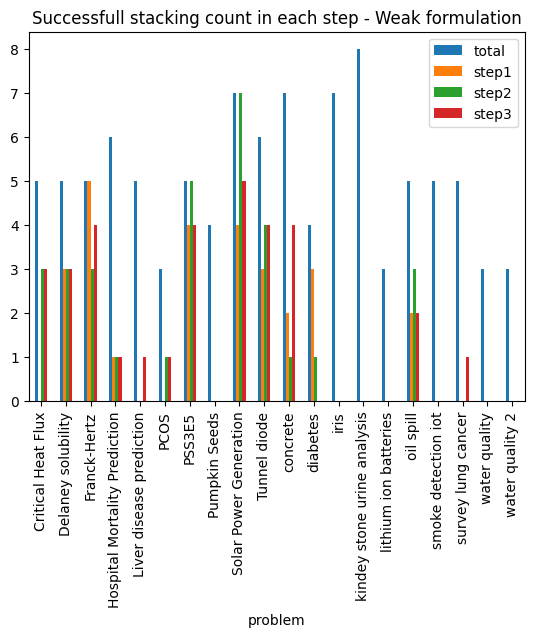

In [19]:
sql = """ select total.name as problem, total.count as total, ifnull(step_1.count, 0) as step1, ifnull(step_2.count, 0) as step2, ifnull(step_3.count, 0) as step3
          from (select name, count(*) as count
                from solution_ext
                group by name) as total
          left outer join 
               (select name, count(*) as count
                from stack_ok
                where stack_ok.step = 1
                and status = 'strong'
                group by name) as step_1
          on total.name = step_1.name
          left outer join 
               (select name, count(*) as count
                from stack_ok
                where stack_ok.step = 2
                and status = 'strong'
                group by name) as step_2
          on total.name = step_2.name
          left outer join 
              (select name, count(*) as count
               from stack_ok
               where stack_ok.step = 3
                and status = 'strong'
               group by name) as step_3
          on total.name = step_3.name
     """
data = pd.read_sql(sql, conn)
data_2_strong = data.copy()
data.set_index('problem').plot.bar()
plt.title("Successfull stacking count in each step - Weak formulation")
plt.show()

### Weak formulation

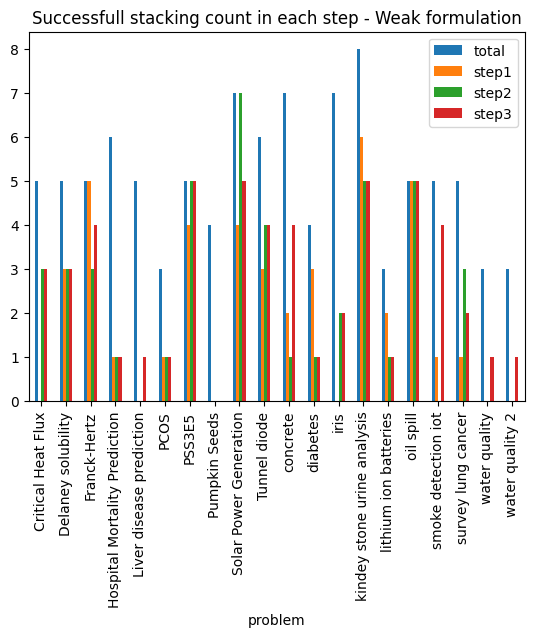

In [20]:
sql = """ select total.name as problem, total.count as total, ifnull(step_1.count, 0) as step1, ifnull(step_2.count, 0) as step2, ifnull(step_3.count, 0) as step3
          from (select name, count(*) as count
                from solution_ext
                group by name) as total
          left outer join 
               (select name, count(*) as count
                from stack_ok
                where stack_ok.step = 1
                group by name) as step_1
          on total.name = step_1.name
          left outer join 
               (select name, count(*) as count
                from stack_ok
                where stack_ok.step = 2
                group by name) as step_2
          on total.name = step_2.name
          left outer join 
              (select name, count(*) as count
               from stack_ok
               where stack_ok.step = 3
               group by name) as step_3
          on total.name = step_3.name
     """
data = pd.read_sql(sql, conn)
data_2_weak = data.copy()
data.set_index('problem').plot.bar()
plt.title("Successfull stacking count in each step - Weak formulation")
plt.show()

The following problems:
- Liver disease prediction
- concrete
- water quality
- water quality 2 
and to a lesser extent the problem:
- Critical Heat Flux 
benefit from the optimization process, because no solution were found at step1 and at least one solution at step3.

The problems Pumkin Seeds and iris do not benefit.

## Check if the two versions are equivalent

In [21]:
data_1_strong.compare(data_2_strong)

Empty DataFrame
Columns: []
Index: []

In [22]:
data_1_weak.compare(data_2_weak)

Empty DataFrame
Columns: []
Index: []

No differences detected.

# Tree vs. Regression

This part is limited to weak formulation.

### Tree

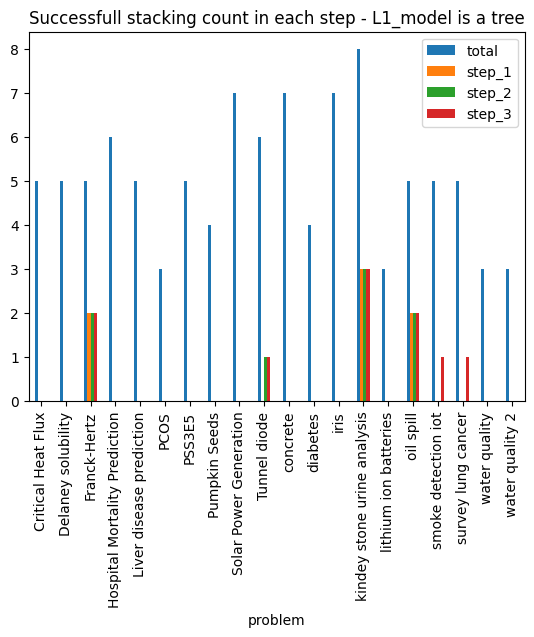

In [23]:
sql = """ select total.name as problem, total.count as total, ifnull(step_1.count, 0) as step_1, ifnull(step_2.count, 0) as step_2, ifnull(step_3.count, 0) as step_3
          from (select name, count(*) as count
                from solution_ext
                group by name) as total
          left outer join 
               (select name, count(*) as count
                from stack_ok
                where stack_ok.step = 1
                and L1_model = 'tree'
                group by name) as step_1
          on total.name = step_1.name
          left outer join 
               (select name, count(*) as count
                from stack_ok
                where stack_ok.step = 2
                and L1_model = 'tree'
                group by name) as step_2
          on total.name = step_2.name
          left outer join 
               (select name, count(*) as count
                from stack_ok
                where stack_ok.step = 3
                and L1_model = 'tree'
                group by name) as step_3
          on total.name = step_3.name
     """
data = pd.read_sql(sql, conn)
data.set_index('problem').plot.bar()
plt.title("Successfull stacking count in each step - L1_model is a tree")
plt.show()

### Regression

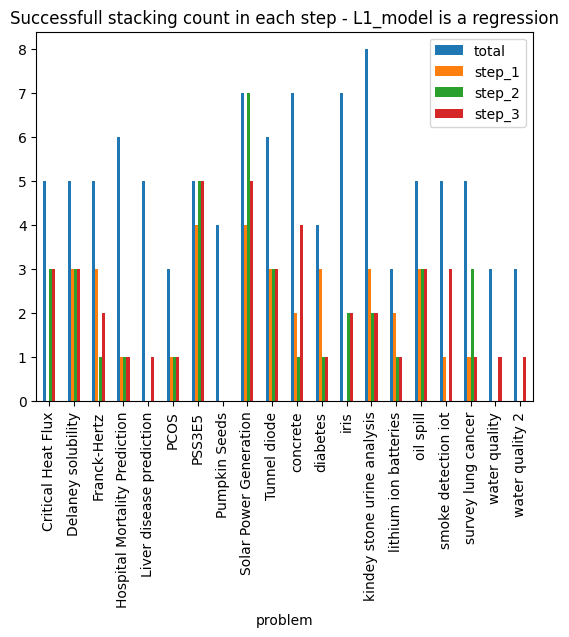

In [24]:
sql = """ select total.name as problem, total.count as total, ifnull(step_1.count, 0) as step_1, ifnull(step_2.count, 0) as step_2, ifnull(step_3.count, 0) as step_3
          from (select name, count(*) as count
                from solution_ext
                group by name) as total
          left outer join 
               (select name, count(*) as count
                from stack_ok
                where stack_ok.step = 1
                and L1_model = 'regression'
                group by name) as step_1
          on total.name = step_1.name
          left outer join 
               (select name, count(*) as count
                from stack_ok
                where stack_ok.step = 2
                and L1_model = 'regression'
                group by name) as step_2
          on total.name = step_2.name
          left outer join 
               (select name, count(*) as count
                from stack_ok
                where stack_ok.step = 3
                and L1_model = 'regression'
                group by name) as step_3
          on total.name = step_3.name
     """
data = pd.read_sql(sql, conn)
data.set_index('problem').plot.bar()
plt.title("Successfull stacking count in each step - L1_model is a regression")
plt.show()

# Influence of the score threshold 

For each of the successful stacked models (based on weak formulation), let's see which value of the score threshold was used.

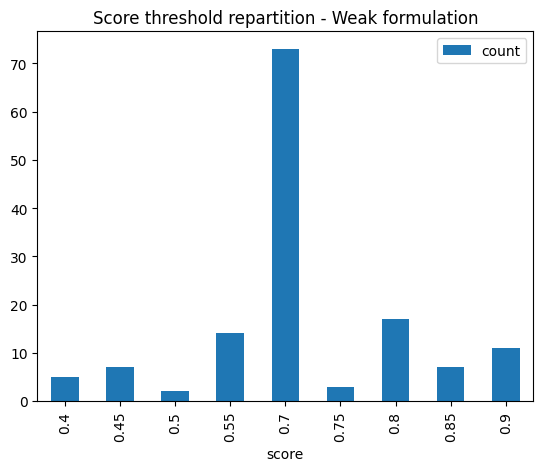

In [25]:
sql = """select solution.score as score, count(*) as count
         from
           (select A.name, A.version, A.step
            from (select name, version, step, max(test_score) as max_test_score 
                  from model_score where model not in ('Stack') 
                  group by name, version, step) as A
            inner join 
                 (select name, version, step, test_score as stack_score 
                  from model_score 
                  where model = 'Stack') as B
            on A.name = B.name
            and A.version = B.version
            and A.step = B.step
            where A.max_test_score <= B.stack_score
            group by A.name, A.version, A.step) as stack
         inner join
            solution
         on stack.name = solution.name
         and stack.version = solution.version
         group by solution.score
      """ 

data = pd.read_sql(sql, conn)
data.set_index('score').plot.bar()
# plt.xticks(rotation='vertical')
plt.title("Score threshold repartition - Weak formulation")
plt.show()

The default value of the score threshold is 0.7 (that is not a real good score for an estimator). Here, for some problems. to reach the successful stacking, it have been sometimes necessary to used low threshold (less than 0.5), that is _very low_.

Let's see which problems used these low threshold:

In [26]:
sql = """select solution.name as problem, solution.score as score_threshold
         from
           (select A.name, A.version, A.step
            from (select name, version, step, max(test_score) as max_test_score 
                  from model_score where model not in ('Stack') 
                  group by name, version, step) as A
            inner join 
                 (select name, version, step, test_score as stack_score 
                  from model_score 
                  where model = 'Stack') as B
            on A.name = B.name
            and A.version = B.version
            and A.step = B.step
            where A.max_test_score <= B.stack_score
            group by A.name, A.version, A.step) as stack
         inner join
            solution
         on stack.name = solution.name
         and stack.version = solution.version
         where solution.score <= 0.5
         group by solution.score
      """ 

data = pd.read_sql(sql, conn)
data

,problem,score_threshold
0,Franck-Hertz,0.40
1,Franck-Hertz,0.45
2,lithium ion batteries,0.50


Similary, which problems used high threshold (greater than 0.8):

In [27]:
sql = """select solution.name as problem, solution.score as score_threshold
         from
           (select A.name, A.version, A.step
            from (select name, version, step, max(test_score) as max_test_score 
                  from model_score where model not in ('Stack') 
                  group by name, version, step) as A
            inner join 
                 (select name, version, step, test_score as stack_score 
                  from model_score 
                  where model = 'Stack') as B
            on A.name = B.name
            and A.version = B.version
            and A.step = B.step
            where A.max_test_score <= B.stack_score
            group by A.name, A.version, A.step) as stack
         inner join
            solution
         on stack.name = solution.name
         and stack.version = solution.version
         where solution.score >= 0.8
         group by solution.score
      """ 

data = pd.read_sql(sql, conn)
data

,problem,score_threshold
0,Critical Heat Flux,0.80
1,PCOS,0.85
2,lithium ion batteries,0.90


In fact, the only problem needing a low threshold is the [Franck-Hertz's problem](https://www.kaggle.com/code/philippebillet/franck-hertz-stacking-and-model-importance).

# Model rankings

In this part the notion of step is not taking in account, we only consider overall rankings (counting how many times the model is the best).

## According to their score

### Classification problems

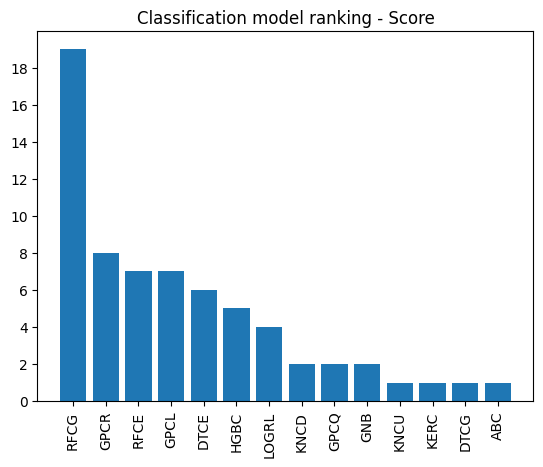

In [28]:
sql = """ select model, count(*) as count
          from (select model, max(test_score)
                from model_score
                where model != 'Stack'
                and name in (select name
                             from problem
                             where type = 'classification')
                group by name, version)
          group by model
          order by count desc
      """ 

data = pd.read_sql(sql, conn)
plt.bar(data['model'], data['count'])
plt.xticks(rotation='vertical')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Classification model ranking - Score")
plt.show()

### Regression problems

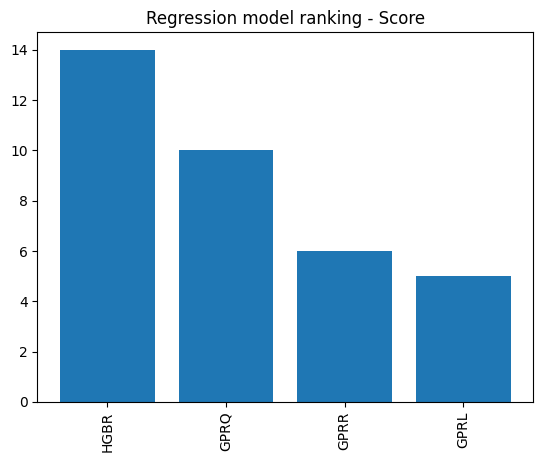

In [29]:
sql = """ select model, count(*) as count
          from (select model, max(test_score)
                from model_score
                where model != 'Stack'
                and name in (select name
                             from problem
                             where type = 'regression')
                group by name, version)
          group by model
          order by count desc
      """ 

data = pd.read_sql(sql, conn)
plt.bar(data['model'], data['count'])
plt.xticks(rotation='vertical')
plt.title("Regression model ranking - Score")
plt.show()

## According to their importance

### Classification problems

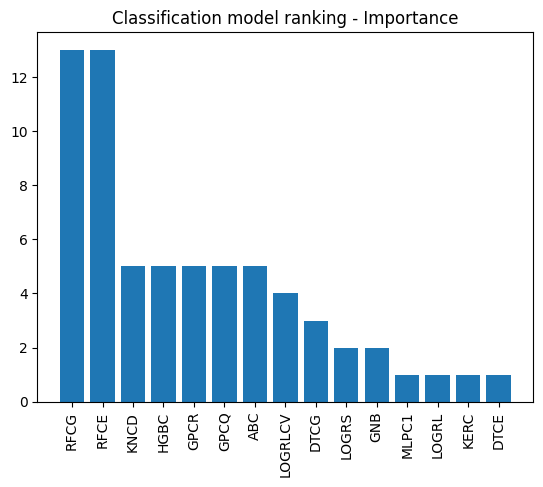

In [30]:
sql = """ select model, count(*) as count
          from (select model, max(importance)
                from model_importance
                where name in (select name
                               from problem
                               where type = 'classification')
                group by name, version)
          group by model
          order by count desc
      """ 

data = pd.read_sql(sql, conn)
plt.bar(data['model'], data['count'])
plt.xticks(rotation='vertical')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Classification model ranking - Importance")
plt.show()

### Regression problems

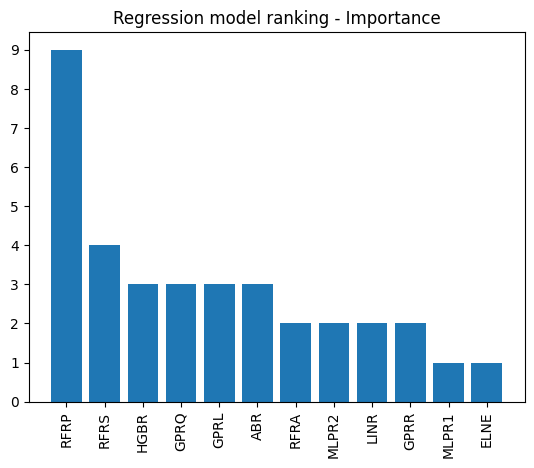

In [31]:
sql = """ select model, count(*) as count
          from (select model, max(importance)
                from model_importance
                where name in (select name
                               from problem
                               where type = 'regression')
                group by name, version)
          group by model
          order by count desc
      """ 

data = pd.read_sql(sql, conn)
plt.bar(data['model'], data['count'])
plt.xticks(rotation='vertical')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Regression model ranking - Importance")
plt.show()

# Feature elimination ratio

## When stacking worked

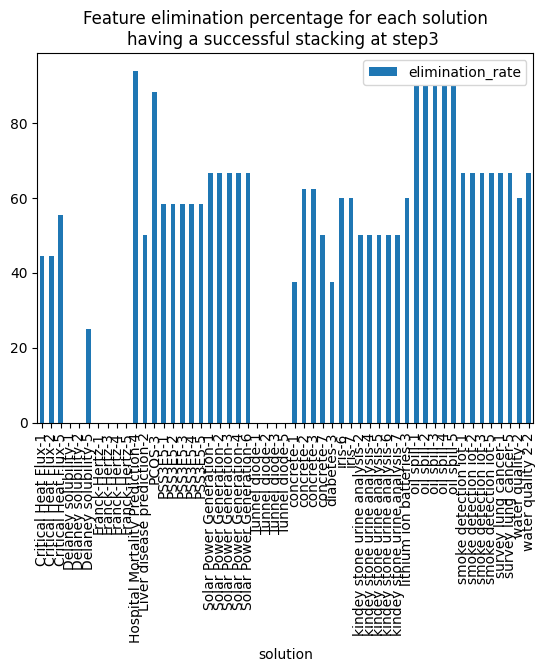

In [32]:
sql = """ select a.name || '-' || a.version as solution, (1 - (cast(b.filtered_feature as real) / cast(a.total_feature as real))) * 100 as elimination_rate
          from (select stack_ok.name, stack_ok.version, count(*) as total_feature
                from stack_ok 
                inner join eda 
                on stack_ok.name = eda.name
                and stack_ok.version = eda.version
                where stack_ok.step = 3
                and eda.target = 0
                group by stack_ok.name, stack_ok.version) as a
          inner join (
                select feature_importance.name, feature_importance.version, count(*) as filtered_feature
                from feature_importance
                inner join stack_ok
                on feature_importance.name = stack_ok.name
                and feature_importance.version = stack_ok.version
                and feature_importance.step = stack_ok.step
                where feature_importance.step = 3
                group by feature_importance.name, feature_importance.version) as b    
          on a.name = b.name
          and a.version = b.version
      """

data = pd.read_sql(sql, conn)
data.set_index('solution').plot.bar()
plt.title("Feature elimination percentage for each solution\nhaving a successful stacking at step3 ")
plt.show()

## Globally

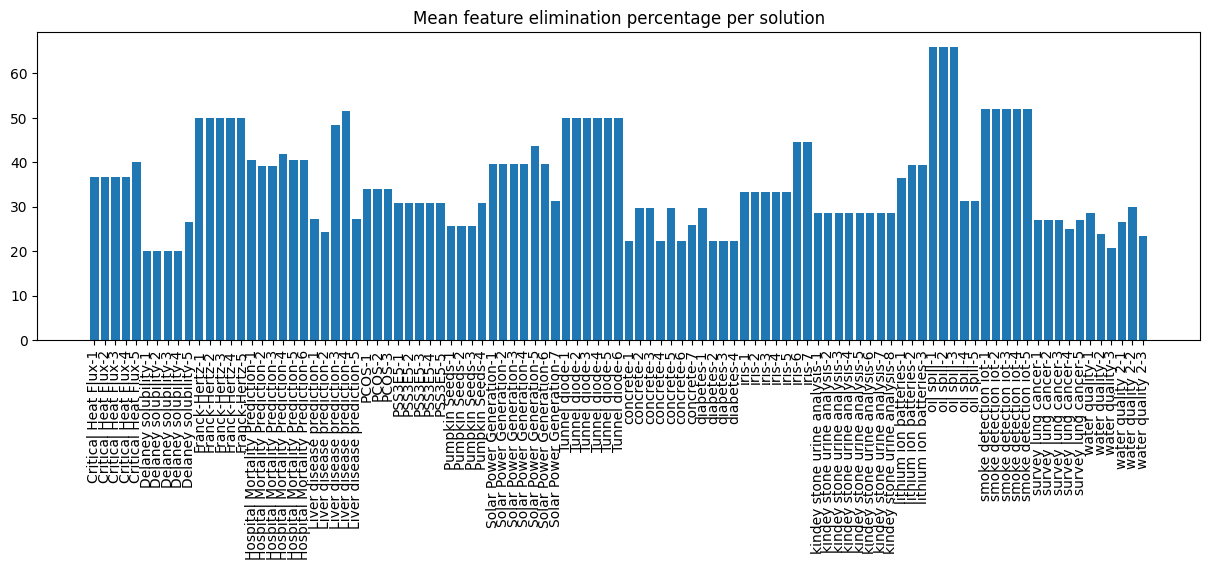

In [33]:
sql = """select a.name || '-' || a.version as solution, 
         (1 - (cast(B.feature_mean as real) / cast(A.feature_total as real))) * 100 as elimination_rate
         from 
           (select eda.name, eda.version, count(*) as feature_total
            from eda
            group by eda.name, eda.version) as A
         inner join
           (select a.name, a.version, avg(a.feature_step) as feature_mean
            from (
              select name, version, step, count(*) as feature_step
              from feature_importance
              group by name, version, step) as a
            group by a.name, a.version) as B
         on A.name = B.name
         and A.version = B.version
      """

data = pd.read_sql(sql, conn)
plt.figure(figsize=(15,4))
plt.bar(data['solution'], data['elimination_rate'])
plt.xticks(rotation='vertical')
plt.title("Mean feature elimination percentage per solution")
plt.show()

# Stacking gain

In this section, we will study the variation in scores between each step.

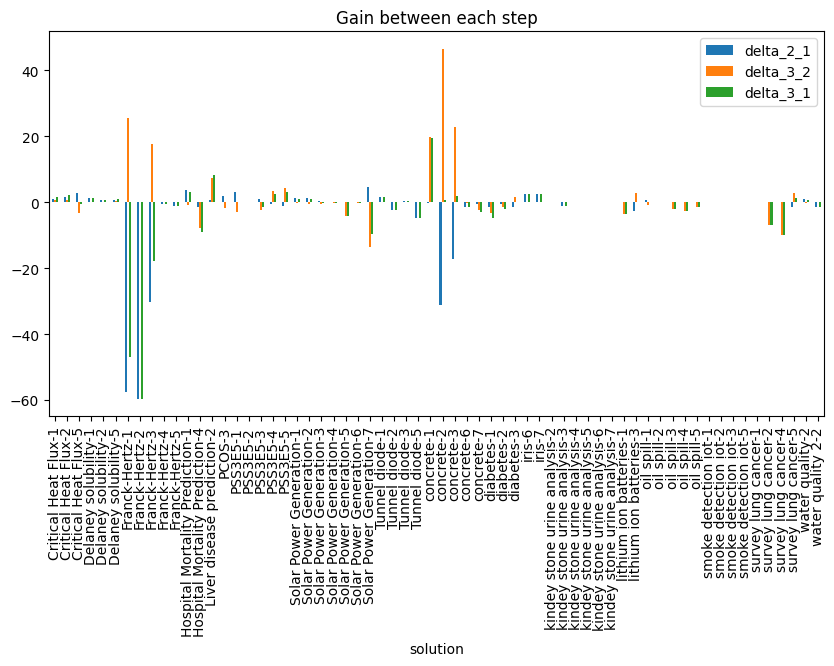

In [34]:
sql = """select a.name || '-' || a.version as solution, 
         ((score_2 - score_1)*100/score_1) as delta_2_1,
         ((score_3 - score_2)*100/score_2) as delta_3_2,
         ((score_3 - score_1)*100/score_1) as delta_3_1
         from stack_ok_score as a
      """

data = pd.read_sql(sql, conn)
plt.rcParams["figure.figsize"] = [10, 5]
data.set_index('solution').plot.bar()
plt.title("Gain between each step")
plt.show()

We see that the solutions of the [Franck-Hertz problem](https://www.kaggle.com/code/philippebillet/franck-hertz-stacking-and-model-importance/notebook) are sometimes very poor.
Let's see it in detail:

The high losses of performance are certainly due to a bad choice of hyperparameters. 

In [35]:
sql = """select distinct A.name, A.version, A.correlation, A.nb_model,
                A.nb_feature, A.score, A.test_size, A.resampling, B.L1_model,
                C.score_1, C.score_2, C.score_3
         from solution as A
         inner join model as B
         on A.name = B.name
         and A.version = B.version
         inner join stack_ok_score as C
         on A.name = C.name
         and A.version = C.version         
         where A.name = 'Franck-Hertz'
      """

data = pd.read_sql(sql, conn)
data.style.background_gradient(subset=["score_1", "score_2", "score_3"], cmap="Reds")

,name,version,correlation,nb_model,nb_feature,score,test_size,resampling,L1_model,score_1,score_2,score_3
0,Franck-Hertz,1,0.750000,5,5,0.400000,0.330000,0,regression,0.993783,0.420510,0.528347
1,Franck-Hertz,2,0.750000,3,5,0.450000,0.330000,0,regression,0.982485,0.396274,0.396274
2,Franck-Hertz,3,0.750000,7,5,0.400000,0.330000,0,regression,0.981189,0.684721,0.805571
3,Franck-Hertz,4,0.750000,5,5,0.450000,0.330000,0,tree,0.979284,0.975546,0.975546
4,Franck-Hertz,5,0.750000,3,5,0.450000,0.330000,0,tree,0.976929,0.965877,0.965877


Let's cap the low scores:

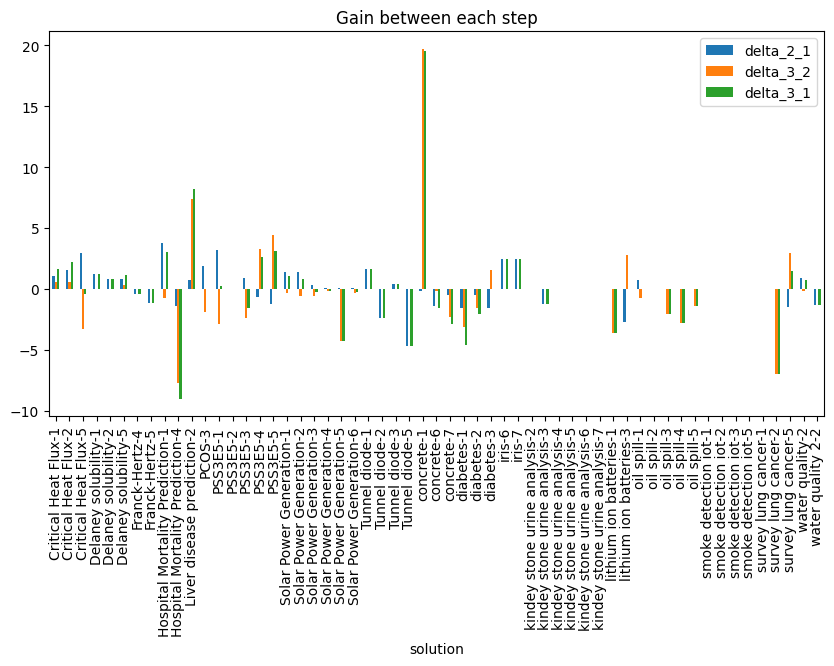

In [36]:
sql = """select a.name || '-' || a.version as solution, 
         ((score_2 - score_1)*100/score_1) as delta_2_1,
         ((score_3 - score_2)*100/score_2) as delta_3_2,
         ((score_3 - score_1)*100/score_1) as delta_3_1
         from stack_ok_score as a
         where delta_2_1 > -10
         and delta_3_2 > -10 
         and delta_3_1 > -10
      """

data = pd.read_sql(sql, conn)
data.set_index('solution').plot.bar()
plt.title("Gain between each step")
plt.show()

[Concrete problem](https://www.kaggle.com/code/philippebillet/concrete-stacking-and-model-importance) in detail

In [37]:
sql = """select distinct A.name, A.version, A.correlation, A.nb_model,
                A.nb_feature, A.score, A.test_size, A.resampling, B.L1_model,
                C.score_1, C.score_2, C.score_3
         from solution as A
         inner join model as B
         on A.name = B.name
         and A.version = B.version
         inner join stack_ok_score as C
         on A.name = C.name
         and A.version = C.version
         where A.name = 'concrete'
      """

data = pd.read_sql(sql, conn)
data.style.background_gradient(subset=["score_1", "score_2", "score_3"], cmap="Reds")

,name,version,correlation,nb_model,nb_feature,score,test_size,resampling,L1_model,score_1,score_2,score_3
0,concrete,1,0.750000,5,5,0.700000,0.330000,0,regression,0.749124,0.747826,0.895205
1,concrete,2,0.750000,3,3,0.700000,0.330000,0,regression,0.749124,0.515372,0.755091
2,concrete,3,0.750000,4,3,0.700000,0.330000,0,regression,0.749124,0.620436,0.762414
3,concrete,6,0.750000,5,5,0.700000,0.300000,0,regression,0.910354,0.897905,0.896220
4,concrete,7,0.750000,6,4,0.800000,0.330000,0,regression,0.906014,0.901209,0.880333


# Close connection

In [38]:
# conn.close()

## References

The documentation of [EZStacking](https://github.com/phbillet/EZStacking) already gives some references, a basic research like: [stacking "model importance" in Google Scholar](https://scholar.google.cz/scholar?q=stacking+%22model+importance%22&hl=fr&as_sdt=0&as_vis=1&oi=scholart) shows that the suject is far from being uninteresting.